# Project: No-Show in the Brazilian Public Health System

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

The dataset in this analysis contains more than one-hundred thousand entries regarding no-show in the Brazilian public health system (Sistema Único de Saúde - SUS) between April 29 2016 and June 8 2016. Each entry has a unique appointment ID along with information about the patient. The information available is the following: a patient ID; sex; day and time of scheduling; day of the appointment; age; neighbourhood of the medical center; whether the patient receives money from Bolsa Família, a social welfare program of the Government of Brazil; whether the patient has hypertension, diabetes, alcoholism, or handicaps; whether an SMS was received reminding the patient of the appointment; and whether this event was a no-show.

The aim is to investigate tendencies, associations and correlations between some of these variables and no-show. Furthermore, analyze how the variables affect each other. 

Apart from age and sex, the first possibly relevant variable that comes to mind is the participation in Bolsa Família. Participants in this welfare program are demanded to comply with a set of rules designed, among other things, to 1) keep the children of families in poverty and extremy poverty in school rather than working; 2) and keep them properly immunized in order to avoid latent diseases in poor areas. Do these children miss less appointments than the remaining patients?

Other possible associations between various health conditions and no-show could shed some light on whether certain subsets of patients could profit from specific policies aimed at decreasing no-show.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
import matplotlib
import numpy as np
import seaborn as sns
%matplotlib inline

style.use('seaborn-notebook')
style.use('ggplot')

<a id='wrangling'></a>
## Data Wrangling

### General Properties

In [2]:
df = pd.read_csv('noshowappointments-kagglev2-may-2016.csv')
df.columns

Index(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hipertension',
       'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show'],
      dtype='object')

In [3]:
df.shape

(110527, 14)

In [4]:
df.head(3)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No


### Data Cleaning

In [5]:
# Normalizing the column names, correcting typos in 'handicap' and 'hypertension', 
# and renaming 'gender' as 'sex' in order to better comply with the current debate around the issue. 
# See: [https://www.who.int/gender-equity-rights/knowledge/glossary/en/]

df.columns = [x.strip().lower().replace('-', '_') for x in df.columns]
df.rename({'patientid':'patient_id', 'scheduledday':'scheduled_day', 'appointmentday':'appointment_day',
           'hipertension':'hypertension', 'handcap':'handicap', 
           'gender':'sex'}, axis='columns', inplace=True)
df.head(1)

,patient_id,appointmentid,sex,scheduled_day,appointment_day,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no_show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No


In [6]:
# Checking for NA values.

df.isna().sum()

patient_id         0
appointmentid      0
sex                0
scheduled_day      0
appointment_day    0
age                0
neighbourhood      0
scholarship        0
hypertension       0
diabetes           0
alcoholism         0
handicap           0
sms_received       0
no_show            0
dtype: int64

In [7]:
# Checking for duplicates.

df['appointmentid'].duplicated().sum()

0

In [8]:
# Since 'appointmentid' is a unique identifier which is otherwise of no relevance for the analysis, the column is dropped below.

df.drop(['appointmentid'], axis=1, inplace=True)

In [9]:
df['patient_id'].nunique()

62299

In [10]:
# 'patient_id' can be a recurring value, a factor which may be significant for the analysis.
# A column 'new_patient' is created below with information on whether a patient is new.

df['new_patient'] = df.groupby(['patient_id']).cumcount().apply(lambda x: 0 if (x > 0) else 1)
print('New patient: \n{}'.format(df.new_patient.value_counts()))

New patient: 
1    62299
0    48228
Name: new_patient, dtype: int64


In [11]:
# Converting dates into datetime objects and creating a 'weekday' column.

df['scheduled_day'], df['appointment_day'] = pd.to_datetime(df['scheduled_day']), pd.to_datetime(df['appointment_day'])
df['weekday'] = df['appointment_day'].dt.weekday

In [12]:
# Dropping the time from both columns, since it is not available in 'appointment_day', 
# and calculating the time difference to 'scheduled_day' in the column 'time_interval'.

df['appointment_day'], df['scheduled_day'] = df['appointment_day'].dt.date, df['scheduled_day'].dt.date
df['time_interval'] = (df.appointment_day - df.scheduled_day)

# Dropping the column 'scheduled_day' and rearranging the columns.

df.drop(['scheduled_day'], axis='columns', inplace=True)
df = df[['patient_id', 'sex', 'appointment_day', 'weekday', 'time_interval', 'age',
       'neighbourhood', 'scholarship', 'hypertension', 'diabetes',
       'alcoholism', 'handicap', 'sms_received', 'new_patient', 'no_show']]

df.head(1)

,patient_id,sex,appointment_day,weekday,time_interval,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,new_patient,no_show
0,2.987250e+13,F,2016-04-29,4,0 days,62,JARDIM DA PENHA,0,1,0,0,0,0,1,No


In [13]:
# Checking the distribution of the values in the column 'handicap'.

df['handicap'].value_counts()

0    108286
1      2042
2       183
3        13
4         3
Name: handicap, dtype: int64

In [14]:
# Converting the variables below into numeric and additionally binarizing 'handicap'.
# The convertion is necessary in order to calculate the correlations.

df['no_show'] = df.no_show.apply(lambda x: 0 if (x == 'No') else 1)
df['sex'] = df.sex.apply(lambda x: 0 if (x == 'F') else 1)
df['handicap'] = df.handicap.apply(lambda x: 0 if (x == 0) else 1)

# Health check.

print('No-show: \n{}'.format(df.no_show.value_counts()))
print('Sex: \n{}'.format(df.sex.value_counts()))
print('Handicap: \n{}'.format(df.handicap.value_counts()))

No-show: 
0    88208
1    22319
Name: no_show, dtype: int64
Sex: 
0    71840
1    38687
Name: sex, dtype: int64
Handicap: 
0    108286
1      2241
Name: handicap, dtype: int64


In [15]:
# Converting 'time_interval' into numeric.

df['time_interval'] = df['time_interval'] / np.timedelta64(1, 'D')
df.query('time_interval < 0')

,patient_id,sex,appointment_day,weekday,time_interval,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,new_patient,no_show
27033,7.839273e+12,1,2016-05-09,0,-1.0,38,RESISTÊNCIA,0,0,0,0,1,0,0,1
55226,7.896294e+12,0,2016-05-17,1,-1.0,19,SANTO ANTÔNIO,0,0,0,0,1,0,0,1
64175,2.425226e+13,0,2016-05-04,2,-1.0,22,CONSOLAÇÃO,0,0,0,0,0,0,0,1
71533,9.982316e+14,0,2016-05-05,3,-6.0,81,SANTO ANTÔNIO,0,0,0,0,0,0,0,1
72362,3.787482e+12,1,2016-05-03,1,-1.0,7,TABUAZEIRO,0,0,0,0,0,0,1,1


In [16]:
# Dropping rows with time interval smaller than 0.

df = df[df.time_interval >= 0]

In [17]:
# Cheking the column 'age'.

df.query('age < 0')

,patient_id,sex,appointment_day,weekday,time_interval,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,new_patient,no_show
99832,4.659432e+14,0,2016-06-06,0,0.0,-1,ROMÃO,0,0,0,0,0,0,1,0


In [18]:
df.query('age > 60').count()['age']

19761

In [19]:
df.query('age > 80').count()['age']

2851

In [20]:
df.age.value_counts()

 0      3539
 1      2273
 52     1746
 49     1652
 53     1651
        ... 
 115       5
 100       4
 102       2
 99        1
-1         1
Name: age, Length: 104, dtype: int64

In [21]:
# Dropping rows with age smaller than 0 - an impossibility - and bigger than 80.
# The latter aims to prevent outliers from affecting analysis accuracy.

df = df[df.age >= 0]
df = df[df.age <= 80]

In [22]:
df.head(3)

,patient_id,sex,appointment_day,weekday,time_interval,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,new_patient,no_show
0,2.987250e+13,0,2016-04-29,4,0.0,62,JARDIM DA PENHA,0,1,0,0,0,0,1,0
1,5.589978e+14,1,2016-04-29,4,0.0,56,JARDIM DA PENHA,0,0,0,0,0,0,1,0
2,4.262962e+12,0,2016-04-29,4,0.0,62,MATA DA PRAIA,0,0,0,0,0,0,1,0


In [23]:
df.describe()

,patient_id,sex,weekday,time_interval,age,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,new_patient,no_show
count,1.076700e+05,107670.000000,107670.000000,107670.000000,107670.000000,107670.000000,107670.000000,107670.000000,107670.000000,107670.000000,107670.000000,107670.000000,107670.000000
mean,1.476342e+14,0.350720,1.858447,10.135330,35.810746,0.100799,0.185762,0.068329,0.031011,0.018585,0.322764,0.562933,0.202898
std,2.562386e+14,0.477198,1.371909,15.049817,22.009345,0.301063,0.388916,0.252311,0.173349,0.135053,0.467535,0.496026,0.402159
min,3.921784e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.158482e+12,0.000000,1.000000,0.000000,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.165420e+13,0.000000,2.000000,4.000000,36.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,9.442195e+13,1.000000,3.000000,15.000000,54.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,9.999816e+14,1.000000,5.000000,179.000000,80.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Now the dataset is clean and ready to be analyzed.

<a id='eda'></a>
## Exploratory Data Analysis

### 1. What is the distribution of no-show by age and sex?

In [24]:
print('Proportion of no-show in the whole dataset: {}'.format(len(df.query('no_show == 1')) / len(df.no_show)))

Proportion of no-show in the whole dataset: 0.20289774310392866


In [25]:
# Defining a function to facilitate plotting.

def plot (data, suptitle, ylabel, xlabel, xticklabels, kind='line', rotation=0):
    ax = data.plot(legend=False, figsize=(8, 5), kind=kind);
    plt.subplots_adjust(top=.9)
    plt.suptitle(suptitle, fontsize=16);
    ax.set_ylabel(ylabel, size=13)
    ax.set_xlabel(xlabel, size=13)
    labels = ([item.get_text() for item in ax.get_xticklabels()])
    ax.set_xticklabels(xticklabels, size=13, rotation=rotation)
    ax.plot();

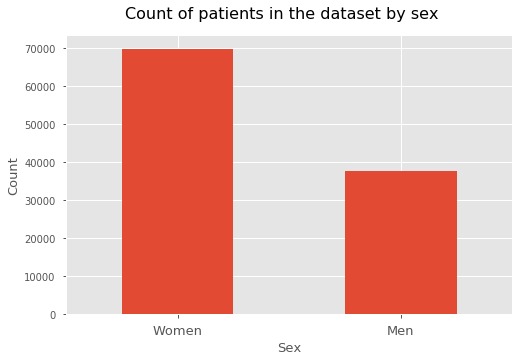

In [26]:
sex = df.sex.value_counts()

plot(sex, suptitle='Count of patients in the dataset by sex', ylabel='Count', xlabel='Sex', kind='bar',
     xticklabels=['Women', 'Men'])

The dataset is comprised roughtly of 1/3 males and 2/3 females. The proportion of no-show in total is 20,3%.

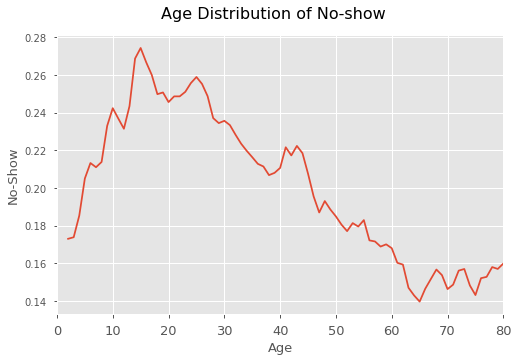

In [27]:
# Grouping the data by age, containing the corresponding mean value for no-show, 
# and plotting its rolling mean with a 3 year window.

age = df.groupby(['age']).agg({'no_show': 'mean'}).rolling(window=3).mean()

plot(age, suptitle='Age Distribution of No-show', ylabel='No-Show', xlabel='Age',
     xticklabels=np.arange(0, 90, 10).tolist())

In [28]:
# Calculating proportion of no-show for children of age up to and including 7 years old
# for a comparison with the remaining patients. Children in that group must be vaccinated. See:
# [https://en.wikipedia.org/wiki/Bolsa_Fam%C3%ADlia] and [https://extranet.who.int/nutrition/gina/en/node/23307]

vaccine = df.query('age <= 7 & scholarship == 1')
remaining_children = df.query('age > 7 & age < 18 & scholarship == 1')
adults = df.query('age >= 18 & scholarship == 1')

print('Percentage of no-show for patients receiving Bolsa Família demanded to follow-up with vaccines: {}'
      .format(len(vaccine.query('no_show == 1')) / len(vaccine)))
      
print('\nPercentage of no-show for remaning children receiving Bolsa Família: {} \nDifference: {} %'
      .format(len(remaining_children.query('no_show == 1')) / len(remaining_children),
              abs(((len(vaccine.query('no_show == 1')) / len(vaccine)) * 100 
                / (len(remaining_children.query('no_show == 1')) / len(remaining_children))) -100)))

print('\nPercentage of no-show for adults receiving Bolsa Família: {} \nDifference: {} %'
      .format(len(adults.query('no_show == 1')) / len(adults),
              abs(((len(vaccine.query('no_show == 1')) / len(vaccine)) * 100 
                / (len(adults.query('no_show == 1')) / len(adults))) -100 )))

Percentage of no-show for patients receiving Bolsa Família demanded to follow-up with vaccines: 0.20098441345365053

Percentage of no-show for remaning children receiving Bolsa Família: 0.2696690179055887 
Difference: 25.469964990929995 %

Percentage of no-show for adults receiving Bolsa Família: 0.23565652676164806 
Difference: 14.712986643932936 %


The age distribution of no-show is skewed to the right. The mean value reaches its peak short before the age of 20, when it starts to lower steadily until around the age of 65, reaching its minimum. 

One particular aspect to analyze regarding the age is that families receiving Bolsa Família with children of 7 years of age or younger need to properly follow-up with their children's immunization in order to remain eligible to the program. Patients in this group are 25% less likely to miss an appointment than the remaining children that receive Bolsa Família, and 14,7% less likely than adults receiving Bolsa Família.

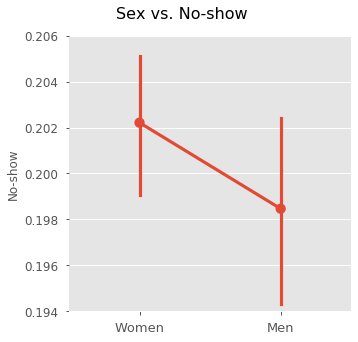

In [29]:
# Sex and No-show
ax = sns.catplot(x="sex", y="no_show", kind="point", data=df);
(ax.set_axis_labels("", "No-show")
    .set_yticklabels(size=12)
    .set_xticklabels(['Women', 'Men'], size=13)
    .set(ylim=(0.196, 0.208))
    .despine(left=True))

plt.subplots_adjust(top=.9)
plt.suptitle('Sex vs. No-show', fontsize=16);

The [estimate of central tendency](https://seaborn.pydata.org/generated/seaborn.pointplot.html#seaborn.pointplot) for no-show by sex shows that men are slightly less likely to miss an appointment than women, but the difference is very small.

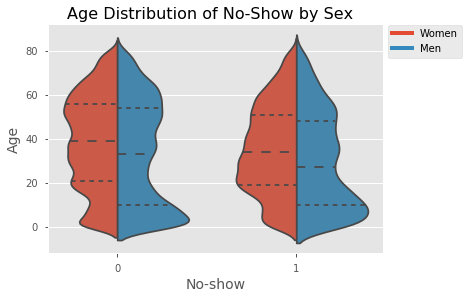

In [30]:
ax = sns.violinplot(x="no_show", y="age", hue="sex",
               split=True, inner="quart", data=df);

plt.subplots_adjust(top=.92)
plt.suptitle('Age Distribution of No-Show by Sex', fontsize=16);
line_up, = plt.plot(df.sex[0], label='Women', linewidth=4)
line_down, = plt.plot(df.sex[1], label='Men', linewidth=4)
plt.legend(handles=[line_up, line_down], bbox_to_anchor=(1.25, 1.02), loc='upper right')
ax.set_xticklabels(['0', '1'])
ax.set_xlabel('No-show', size=14)
ax.set_ylabel('Age', size=14);

The age distribution of sex plotted against no-show reveals that the median age for men in this dataset is smaller than for women. While there is a slight variation in the age distribution of men when segregated by no-show - younger men tend to miss appointments more often than older men -, the distribution for women displays a more significant variation. Younger women tend more than older women to miss appointments.

### 2. How do different health conditions affect no-show? Does sex or participation in Bolsa Família matter?

In [31]:
# Creating a function to plot various health conditions against no-show
# grouped by sex and split by participation in Bolsa Família

def catplot(x, xlabel, suptitle, ylim=(0,.3)):
    fig = plt.figure();
    ax = sns.catplot(x=x, y="no_show", hue="sex", col='scholarship', kind="bar", 
                 data=df, legend=False).set(xlabel=xlabel, ylabel='No-show', ylim=ylim).despine(left=True);
    plt.subplots_adjust(top=.85)
    plt.suptitle(suptitle, fontsize=16)
    line_up, = plt.plot(df.sex[0], label='Women', linewidth=4)
    line_down, = plt.plot(df.sex[1], label='Men', linewidth=4)
    plt.legend(handles=[line_up, line_down], bbox_to_anchor=(1.26, 1.015), loc='upper right')
    ax.set_xticklabels(['No', 'Yes'])
    plt.show();

<Figure size 432x288 with 0 Axes>

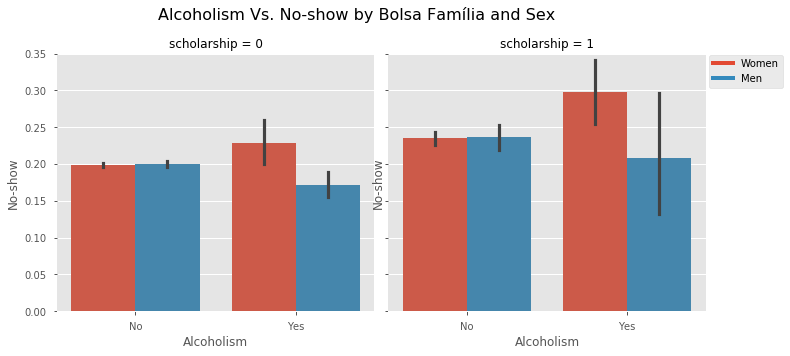

In [32]:
catplot('alcoholism', 'Alcoholism', 'Alcoholism Vs. No-show by Bolsa Família and Sex', ylim=(0,.35))

The plot shows that alcoholic women have a higher tendency of missing an appointment than non-alcoholic women in both scenarions (not receiving and receiving Bolsa Família), while the opposite is true for men. Alcoholic men miss less appointments than non-alcoholic men in both scenarios. For both sexes, however, those who receive Bolsa Família miss more appointments than those who do not.

<Figure size 432x288 with 0 Axes>

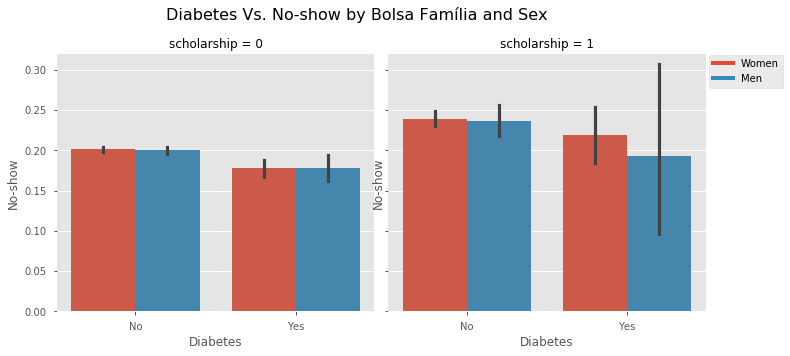

In [33]:
catplot('diabetes', 'Diabetes', 'Diabetes Vs. No-show by Bolsa Família and Sex', ylim=(0,.32))

People who have diabetes miss less appointments in both scenarios, but tend to miss more when receiving Bolsa Família (although the difference is smaller for men, following the same tendency of alcoholism). In fact, like in the previous plot, a higher tendency for missing appointments can be observed for those who receive Bolsa Família in all cases. 

<Figure size 432x288 with 0 Axes>

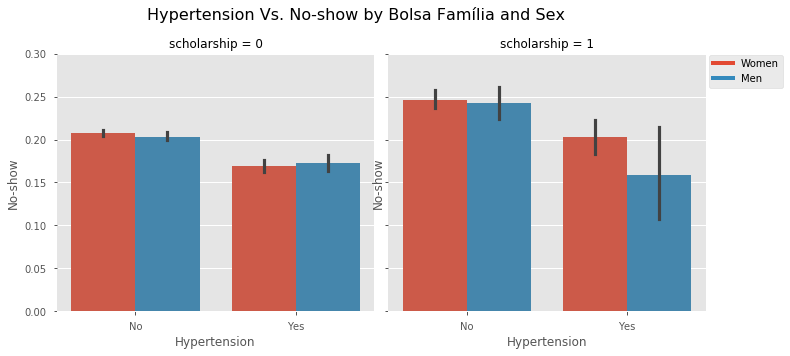

In [34]:
catplot('hypertension', 'Hypertension', 'Hypertension Vs. No-show by Bolsa Família and Sex')

Hypertension presents a similar behavior like diabetes, most likely because of a high correlation between them. This is explored at the end of this section.

<Figure size 432x288 with 0 Axes>

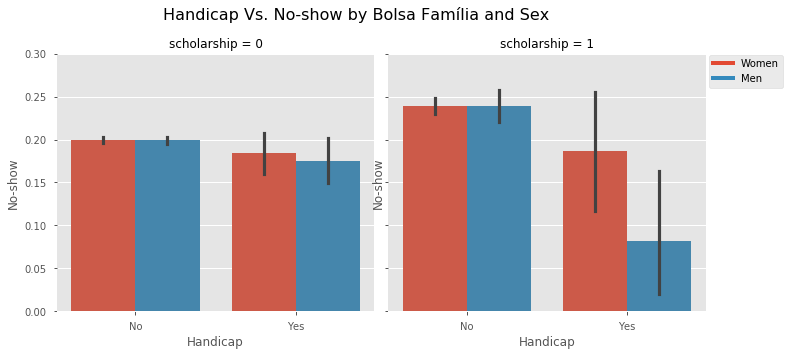

In [35]:
catplot('handicap', 'Handicap', 'Handicap Vs. No-show by Bolsa Família and Sex')

Among those not receiving Bolsa Família, having one or more handicaps does not lower much the tendency of no-show for both sexes (although the variation is higher for men). However, while the tendency of no-show for women with a handicap remains roughly the same when receiving Bolsa Família, men with a handicap have a much lower tendency when receiving it. Nonetheless, since the sample of these cases is rather small, we can also observe long error bars on the plot.

### 3. What are the correlation coeficients of the independent variables with no-show?

In [36]:
# Creating a heatmap to visualize the correlation coeficients among the variables using the corr() function.

def heat_map(df, title):
    corr = df.corr()
    _ , ax = plt.subplots(figsize=(10, 8))
    ax.set_title(title, size=16)
    cmap = sns.diverging_palette(240, 10, as_cmap = True)
    _ = sns.heatmap(corr, cmap=cmap, ax=ax, cbar_kws={'shrink': .8}, annot=True, 
                    annot_kws={'fontsize': 10})
    ax.set_ylim(12.0, 0)

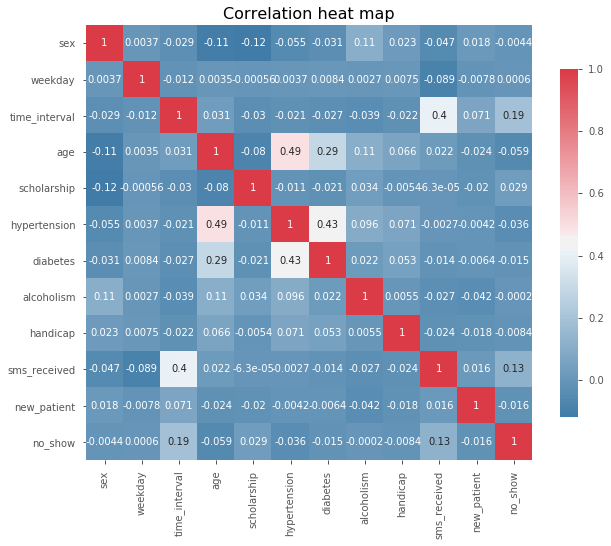

In [37]:
heat_map(df[['sex', 'weekday', 'time_interval',
       'age', 'scholarship', 'hypertension', 'diabetes',
       'alcoholism', 'handicap', 'sms_received', 'new_patient', 'no_show']], 'Correlation heat map')

The heatmap gives us an overview of the correlations among the numerical columns in the data.

Regarding age, there is a very weak negative linear relationship. The same is true for all health conditions in the dataset.

There is a weak positive linear relationship between no-show and time interval, which is the single variable that independently has the highest absolute correlation coeficient with no-show. The correlation coeficient observed between no-show and SMS received is most likely due to the fact that there is a moderate positive correlation between receiving an SMS and the time interval.

<a id='conclusions'></a>
## Conclusions

A rather very weak positive correlation between receiving Bolsa Família and no-show can be observed in the data. The highest correlation observed regarding no-show is with the time interval between the appointment and the scheduling. 

The tendency for no-show is higher for patients receiving Bolsa Família in all cases except for people with one or more handicaps, alcoholic men, or men with hypertension. In general, the introduction of health-related variables lowers the tendency for no-show. Patients until and including the age of 7 who receive Bolsa Família and therefore need to follow-up with immunization have a lower tendency of no-show.

Alcoholism lowers the tendency of no-show for men, while the opposite is true for women. In general, alcoholics receiving Bolsa Família have a higher tendency to miss appointments than alcoholics not receiving Bolsa Família. Diabetes and hypertension associate with a lower tendency of no-show for both sexes and both groups regarding Bolsa Família. Patients with a handicap receiving Bolsa Família have a lower tendency to miss an appointment than those with handicap not receiving it, but patients without a handicap are more likely to miss an appointment when receiving Bolsa Família.

Alcoholic women below the age of 40 who receive Bolsa Família and are otherwise healthy can be considered part of the most susceptible group to missing appointments. Alcoholic men with health conditions such as diabetes and hypertension, not receiving Bolsa Família, and above the age of 40 are part of the least susceptible group to missing appointments.

As to the limitations of this analysis, other correlations and tendencies could have received more focus, perhaps making use of feature engineering based on area expertise. In addition to that, inferencial statistics could boost the analysis and not only produce a more detailed view on the data, but also determine causality.